# Task : Implement a linear regression model to predict the prices of houses based on their square footage and the number of bedrooms and bathrooms.

## 1) Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LinearRegression

## 2) Loading, concatenating and preparing the data

Dataset's link : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [4]:
# Load the test and train files

train= pd.read_csv('train.csv').drop('Id', axis =1)
test = pd.read_csv('test.csv').drop('Id', axis =1)

# Concatenating and subseting to have one DataFrame based on the task's guideline

df = pd.concat([train, test], ignore_index=True)[['LotArea', 'BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'SalePrice']]

df.head()

,LotArea,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
0,8450,3,1.0,0.0,2,1,208500.0
1,9600,3,0.0,1.0,2,0,181500.0
2,11250,3,1.0,0.0,2,1,223500.0
3,9550,3,1.0,0.0,1,0,140000.0
4,14260,4,1.0,0.0,2,1,250000.0


## 3) Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       2919 non-null   int64  
 1   BedroomAbvGr  2919 non-null   int64  
 2   BsmtFullBath  2917 non-null   float64
 3   BsmtHalfBath  2917 non-null   float64
 4   FullBath      2919 non-null   int64  
 5   HalfBath      2919 non-null   int64  
 6   SalePrice     1460 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 159.8 KB


In [6]:
df.isna().sum()

LotArea            0
BedroomAbvGr       0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
SalePrice       1459
dtype: int64

### Comment: 
There're too many rows without sales price. We'll proceed in two times to take the best result

Stage 1: Use the original dataset with the missning values dropped 

Stage 2 : Fill the missing values using a linear regression model, with the missing values as the test set

In [7]:
df_na = df[df['SalePrice'].isna()]
df_na

,LotArea,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
1460,11622,2,0.0,0.0,1,0,NaN
1461,14267,3,0.0,0.0,1,1,NaN
1462,13830,3,0.0,0.0,2,1,NaN
1463,9978,3,0.0,0.0,2,1,NaN
1464,5005,2,0.0,0.0,2,0,NaN
...,...,...,...,...,...,...,...
2914,1936,3,0.0,0.0,1,1,NaN
2915,1894,3,0.0,0.0,1,1,NaN
2916,20000,4,1.0,0.0,1,0,NaN
2917,10441,3,0.0,1.0,1,0,NaN


In [8]:
df.dropna(inplace=True)
df

,LotArea,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
0,8450,3,1.0,0.0,2,1,208500.0
1,9600,3,0.0,1.0,2,0,181500.0
2,11250,3,1.0,0.0,2,1,223500.0
3,9550,3,1.0,0.0,1,0,140000.0
4,14260,4,1.0,0.0,2,1,250000.0
...,...,...,...,...,...,...,...
1455,7917,3,0.0,0.0,2,1,175000.0
1456,13175,3,1.0,0.0,2,0,210000.0
1457,9042,4,0.0,0.0,2,0,266500.0
1458,9717,2,1.0,0.0,1,0,142125.0


## 4) Data preprocessing

### Deleting outliers

In [9]:
Q1 = np.percentile(df['SalePrice'], 25)
Q3 = np.percentile(df['SalePrice'], 75)
IQR = Q3 - Q1
print(IQR)

84025.0


In [10]:
upper = Q3+1.5*IQR
upper_array = np.array(df['SalePrice'] >= upper)
print("Upper Bound:", upper)
print(upper_array.sum())

lower = Q1-1.5*IQR
lower_array = np.array(df['SalePrice'] <= lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 340037.5
61
Lower Bound: 3937.5
0


In [11]:
print(f"Old shape: {df.shape}")

# Filtrer directement le DataFrame
df = df[(df['SalePrice'] < upper) & (df['SalePrice'] > lower)]

print("New Shape:", df.shape)

Old shape: (1460, 7)
New Shape: (1399, 7)


### Stage 1

Plots before training

In [12]:
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']
print(f"X length {len(X)} and shape {X.shape}")
print(f"y length {len(y)} and shape {y.shape}")

X length 1399 and shape (1399, 6)
y length 1399 and shape (1399,)


## 5_1) Spliting the data for raining and testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [14]:
print(f"Training set shape{X_train.shape}")
print(f"Testing set shape{X_test.shape}")
print(f"Training target shape{y_train.shape}")
print(f"Testing target shape{y_test.shape}")

Training set shape(1119, 6)
Testing set shape(280, 6)
Training target shape(1119,)
Testing target shape(280,)


In [15]:
# Instantiate the ppipeline

linregpip = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

In [16]:
# Train

linregpip.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [17]:
# Test

y_pred = linregpip.predict(X_test)

In [18]:
# Evaluate

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [19]:
print(f"The mean squared error is {mse} \nThe root mean squared error is {rmse} \nThe mean absolute error is {mae}\nThe R^2 error is {r2}")

The mean squared error is 1641101535.0746915 
The root mean squared error is 40510.51141462783 
The mean absolute error is 30732.917669631715
The R^2 error is 0.4840629530180518


### Plotting after training

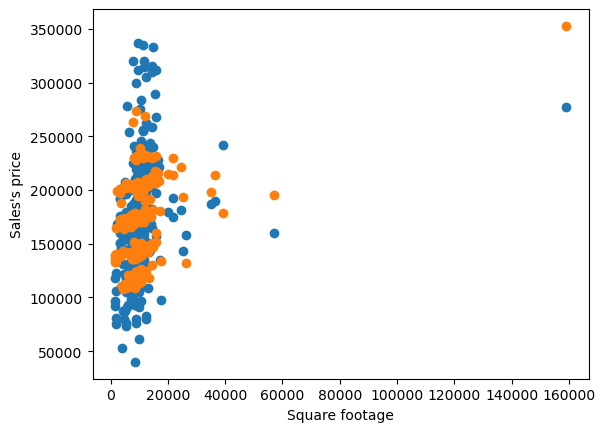

In [20]:
plt.scatter(X_test['LotArea'], y_test)
plt.scatter(X_test['LotArea'], y_pred)
plt.ylabel("Sales's price")
plt.xlabel("Square footage")
plt.show()

In [21]:
#print("Intercept:", linregpip.intercept_)


coeff_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": linregpip.named_steps['linreg'].coef_}).sort_values(by='Coefficient', ascending = False)
print("\nFeature Coefficients:\n", coeff_df)


Feature Coefficients:
         Feature   Coefficient
4      FullBath  33346.452870
2  BsmtFullBath  14305.114789
5      HalfBath  14154.235757
0       LotArea   8710.605300
3  BsmtHalfBath   2668.121145
1  BedroomAbvGr  -3035.040078


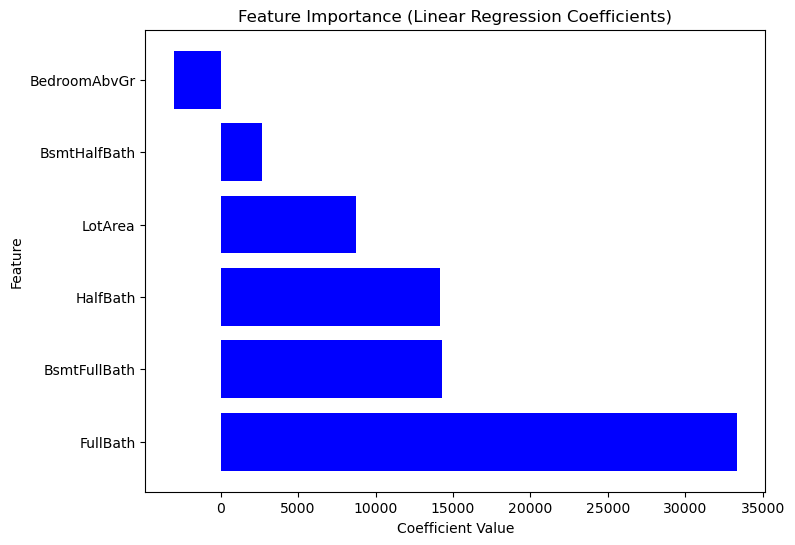

In [22]:
# Sort dataframe by coefficients.
coef_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)


# Create plot.
plt.figure(figsize=(8,6))
plt.barh(coeff_df["Feature"], coef_df_sorted["Coefficient"], color="blue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()

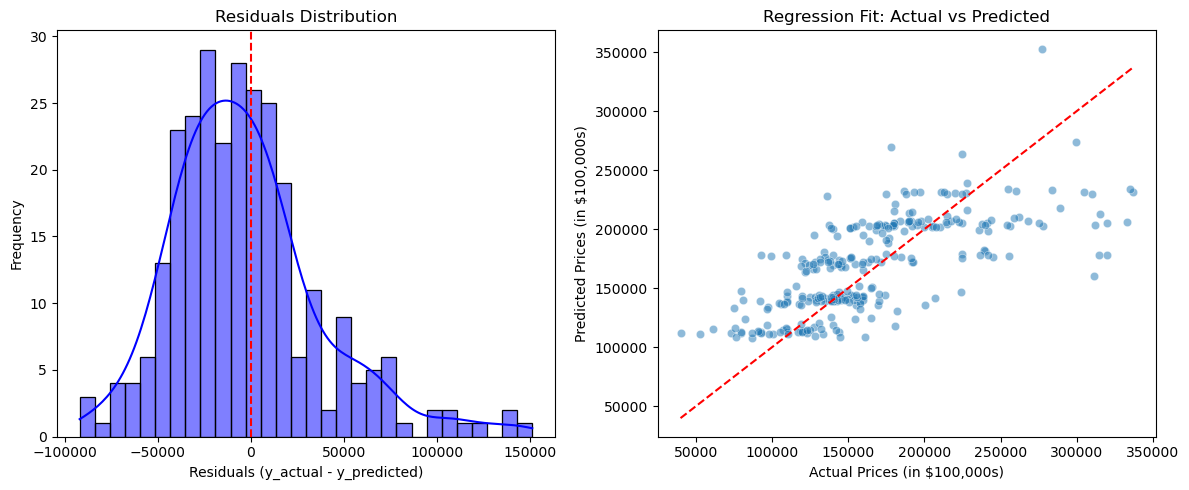

In [23]:
# Compute residuals.
residuals = y_test - y_pred


# Create plots.
plt.figure(figsize=(12,5))


# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")


# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual Prices (in $100,000s)")
plt.ylabel("Predicted Prices (in $100,000s)")


# Show plots.
plt.tight_layout()
plt.show()

### Comment :
Residual Distribution

The residual distribution has an approximately normal shape but with concerning characteristics. The residuals span a very wide range, from approximately -100,000 to +150,000 dollars. The distribution is centered near zero (dashed red line), which is positive, but it shows significant dispersion. The superimposed density curve confirms a near-normal shape, but the spread suggests high variance in prediction errors.

Actual vs. Predicted Plot

The scatter plot shows a positive relationship between actual and predicted prices, but with considerable dispersion. The points deviate substantially from the ideal regression line (dashed red line). In particular, for high prices (above $250,000), the model tends to systematically underestimate the actual values. The variance of the residuals appears to increase with price (heteroscedasticity), which is problematic.

Weaknesses

Significant prediction errors (up to ±$100,000)
Systematic underestimation of high prices
Low overall accuracy

## Stage 2

## 5_2) Data preprocessing

In [24]:
# Training set without missing values

X_train = df.drop('SalePrice', axis = 1)
y_train = df['SalePrice']

In [25]:
X_train.shape

(1399, 6)

In [26]:
# Test set with missing values

X_test = df_na.drop('SalePrice', axis = 1)
y_test = df_na['SalePrice']

In [27]:
X_test.shape

(1459, 6)

In [28]:
X_test.isna().sum()

LotArea         0
BedroomAbvGr    0
BsmtFullBath    2
BsmtHalfBath    2
FullBath        0
HalfBath        0
dtype: int64

In [29]:
dp1=X_test[X_test['BsmtFullBath'].isnull()]
dp2=X_test[X_test['BsmtHalfBath'].isnull()]

In [30]:
# Dropping missing values in the test set's features

X_test = X_test.drop(dp1.index, axis=0)
X_test.isna().sum()

LotArea         0
BedroomAbvGr    0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
dtype: int64

In [31]:
X_test.shape

(1457, 6)

In [32]:
#Dropping the corresponding misssing values in the target

y_test = y_test.drop(dp1.index, axis=0)

In [33]:
y_test.shape

(1457,)

In [34]:
lg = LinearRegression()
lg.fit(X_train, y_train)
predictions = lg.predict(X_test)

In [35]:
predictions.reshape(-1,1)

array([[118303.69410505],
       [145628.34746895],
       [207603.49041231],
       ...,
       [149987.9943727 ],
       [124803.10258779],
       [203024.50011142]])

In [36]:
predictions = pd.DataFrame(predictions)
predictions = predictions.set_axis(['SalePrice'], axis = 1)
predictions = predictions.set_axis(X_test.index, axis = 0)
predictions

,SalePrice
1460,118303.694105
1461,145628.347469
1462,207603.490412
1463,203406.899730
1464,173545.989069
...,...
2914,132194.245780
2915,132148.488560
2916,149987.994373
2917,124803.102588


In [37]:
new_test = pd.concat([X_test, predictions], axis = 1)
new_test

,LotArea,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
1460,11622,2,0.0,0.0,1,0,118303.694105
1461,14267,3,0.0,0.0,1,1,145628.347469
1462,13830,3,0.0,0.0,2,1,207603.490412
1463,9978,3,0.0,0.0,2,1,203406.899730
1464,5005,2,0.0,0.0,2,0,173545.989069
...,...,...,...,...,...,...,...
2914,1936,3,0.0,0.0,1,1,132194.245780
2915,1894,3,0.0,0.0,1,1,132148.488560
2916,20000,4,1.0,0.0,1,0,149987.994373
2917,10441,3,0.0,1.0,1,0,124803.102588


In [38]:
#Concatenating the train set and the new test set to have the new dataset

data = pd.concat([df, new_test], axis = 0)
data.head()

,LotArea,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
0,8450,3,1.0,0.0,2,1,208500.0
1,9600,3,0.0,1.0,2,0,181500.0
2,11250,3,1.0,0.0,2,1,223500.0
3,9550,3,1.0,0.0,1,0,140000.0
4,14260,4,1.0,0.0,2,1,250000.0


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2856 entries, 0 to 2918
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       2856 non-null   int64  
 1   BedroomAbvGr  2856 non-null   int64  
 2   BsmtFullBath  2856 non-null   float64
 3   BsmtHalfBath  2856 non-null   float64
 4   FullBath      2856 non-null   int64  
 5   HalfBath      2856 non-null   int64  
 6   SalePrice     2856 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 178.5 KB


## 5_3) Spliting the data for training and testing

In [40]:
# Outliers

upper = Q3+1.5*IQR
upper_array = np.array(data['SalePrice'] >= upper)
print("Upper Bound:", upper)
print(upper_array.sum())

lower = Q1-1.5*IQR
lower_array = np.array(data['SalePrice'] <= lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 340037.5
4
Lower Bound: 3937.5
0


In [41]:
print(f"Old shape: {data.shape}")

# Filtrer directement le DataFrame
data = data[(data['SalePrice'] < upper) & (data['SalePrice'] > lower)]

print("New Shape:", data.shape)

Old shape: (2856, 7)
New Shape: (2852, 7)


In [42]:
X = data.drop('SalePrice', axis = 1)
y = data['SalePrice']

In [43]:
X_train_new,X_test_new, y_train_new, y_test_new = train_test_split(X,y, test_size = .3, random_state = 42)

## 6) Retraining exactly as in stage 1

In [44]:
print(f"Training set shape{X_train.shape}")
print(f"Testing set shape{X_test.shape}")
print(f"Training target shape{y_train.shape}")
print(f"Testing target shape{y_test.shape}")

Training set shape(1399, 6)
Testing set shape(1457, 6)
Training target shape(1399,)
Testing target shape(1457,)


In [45]:
# Train

linregpip.fit(X_train_new, y_train_new)

Pipeline(steps=[('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [46]:
# Test

y_pred_new = linregpip.predict(X_test_new)

In [47]:
# Evaluate

mse_new = mean_squared_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mse)
mae_new = mean_absolute_error(y_test_new, y_pred_new)
r2_new = r2_score(y_test_new, y_pred_new)

In [48]:
print(f"The mean squared error is {mse_new} \nThe root mean squared error is {rmse_new} \nThe mean absolute error is {mae_new}\nThe R^2 error is {r2_new}")

The mean squared error is 900953423.5617692 
The root mean squared error is 40510.51141462783 
The mean absolute error is 16002.410441944841
The R^2 error is 0.6518434670682287


### Plotting after prediction

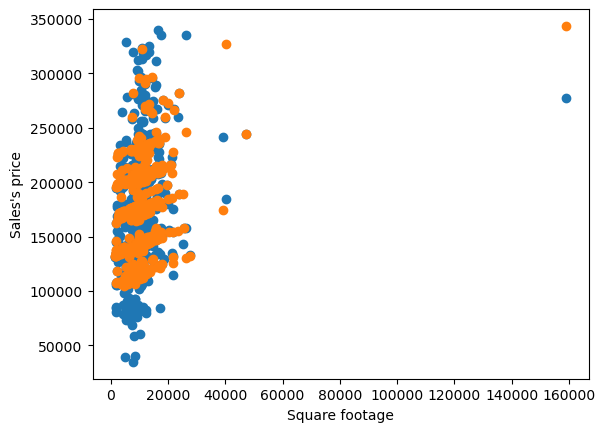

In [49]:
plt.scatter(X_test_new['LotArea'], y_test_new)
plt.scatter(X_test_new['LotArea'], y_pred_new)
plt.ylabel("Sales's price")
plt.xlabel("Square footage")
plt.show()

In [50]:

coeff_data = pd.DataFrame({"Feature": X_train_new.columns, "Coefficient": linregpip.named_steps['linreg'].coef_}).sort_values(by='Coefficient', ascending = False)
print("\nFeature Coefficients:\n", coeff_data)


Feature Coefficients:
         Feature   Coefficient
4      FullBath  33675.332830
2  BsmtFullBath  14060.515725
5      HalfBath  13823.446825
0       LotArea   7250.942663
3  BsmtHalfBath   2632.489169
1  BedroomAbvGr  -2169.733592


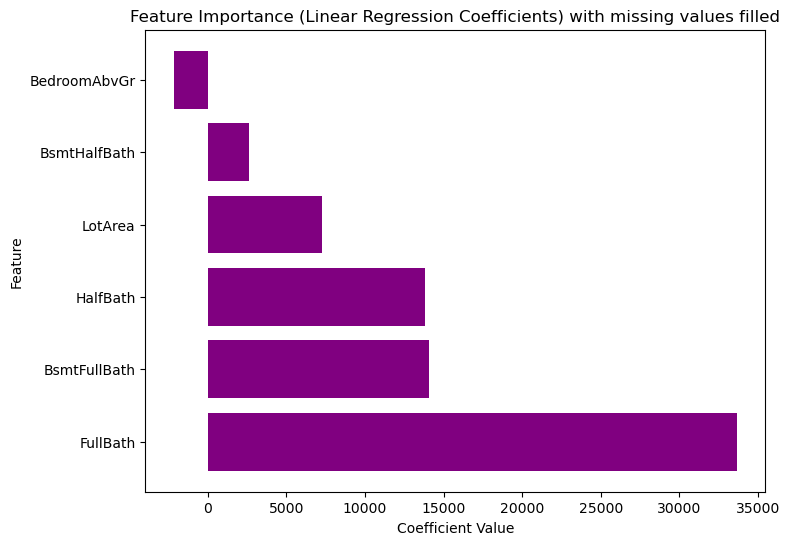

In [51]:
# Sort dataframe by coefficients.
coef_data_sorted = coeff_data.sort_values(by="Coefficient", ascending=False)


# Create plot.
plt.figure(figsize=(8,6))
plt.barh(coeff_df["Feature"], coef_data_sorted["Coefficient"], color="purple")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression Coefficients) with missing values filled")
plt.show()

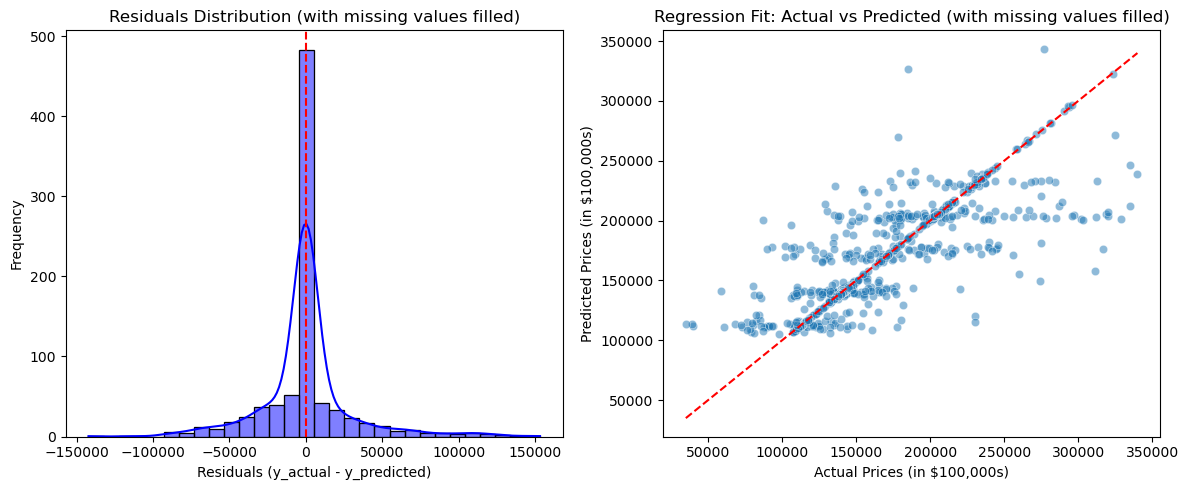

In [52]:
# Compute residuals.
residuals_new = y_test_new - y_pred_new


# Create plots.
plt.figure(figsize=(12,5))


# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
sns.histplot(residuals_new, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution (with missing values filled)")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")


# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_test_new, y=y_pred_new, alpha=0.5)
plt.plot([min(y_test_new), max(y_test_new)], [min(y_test_new), max(y_test_new)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted (with missing values filled)")
plt.xlabel("Actual Prices (in $100,000s)")
plt.ylabel("Predicted Prices (in $100,000s)")


# Show plots.
plt.tight_layout()
plt.show()

### Comment :
Residual Distribution

The residual distribution is remarkably concentrated and symmetrical. The residuals are primarily contained within a narrow range from -$50,000 to +$50,000, roughly half the range of Model 1. The distribution closely follows a normal distribution, as evidenced by the density curve being perfectly aligned with the histogram. The pronounced peak around zero indicates that the majority of predictions are very close to the actual values.

Actual vs. Predicted Graph

The scatter plot is significantly more compact and closely follows the ideal regression line. The points are evenly distributed along the line, without any particular pattern of underestimation or overestimation. The variance of the residuals appears constant across the entire price range (homoscedasticity), which is a sign of a good model. Even at high prices, the model maintains its accuracy.

Key Features

Minimal prediction errors
Perfectly normal residual distribution
Homoscedasticity (constant variance)
Uniform accuracy across the entire price range
No systematic bias

### Comparison Criteria



     Criteria                     Model 1             Model 2 
                         
    Residual Magnitude           ±$100,000            ±$50,000 

    Normality                    Approximate          Excellent 

    Homoscedasticity             Not Met                Met 

    Overall Precision            Low to Medium         High 

    Systematic Bias              Yes (high prices)       No

# CONCLUSION

Model 2 is undeniably superior to Model 1.

Model 2 reduces prediction errors by half compared to Model 1, representing a substantial improvement in predictive performance. Its near-perfect residual distribution and the absence of problematic patterns in the actual vs. predicted graph demonstrate that it better captures the underlying relationships in the data.

For practical applications in real estate price prediction, Model 2 would offer much more reliable and accurate estimates, thus reducing the risk of costly errors. If you had to choose a model to deploy in production, Model 2 would be the obvious choice without hesitation.